# Importing Libraries and Datasets

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import scipy.stats as stats
from sklearn import linear_model, feature_selection, metrics, model_selection, impute, datasets
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

counties_pol_party = pd.read_csv('counties_pol.csv')

In [59]:
agg_select_subset.dtypes

state_abbr                   object
county                       object
fips                         object
school_funding_gap          float64
child_poverty_percentage    float64
income_inequality           float64
firearm_fatalities          float64
median_income               float64
life_expectancy             float64
premature_death             float64
political_party              object
dtype: object

In [ ]:
counties_pol_party.shape
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

In [58]:
# changing fips to str value
agg_select_subset['fips']= agg_select_subset['fips'].astype(str)

## Standardizing Values

In [42]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
counties_pol_copy = counties_pol_party.copy()

In [43]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [44]:
z_counties= calc_z(counties_pol_copy, vars_to_z)

# Variable Selection with Pairwise Mutual Information 

In [45]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_party[[var1]]
        y = counties_pol_party[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.109477               0.072055   
gender_pay_gap                        0.043454               0.003780   
school_segration_index                0.023029               0.043805   
residential_segregation               0.044152               0.012970   
school_funding_gap                    0.226240               0.028641   

                         population  median_income  uninsured__percentage  \
income_inequality          0.026639       0.210404               0.070003   
gender_pay_gap             0.072446       0.023861               0.031068   
school_segration_index     0.172609       0.026639               0.007206   
residential_segregation    0.080649       0.021613               0.070296   
school_funding_gap         0.088495       0.249700               0.251514   

                         premature_death  child_poverty_percentage  \
income_inequality           

## Visualizing Pairwise Mutual Information as Heatmap

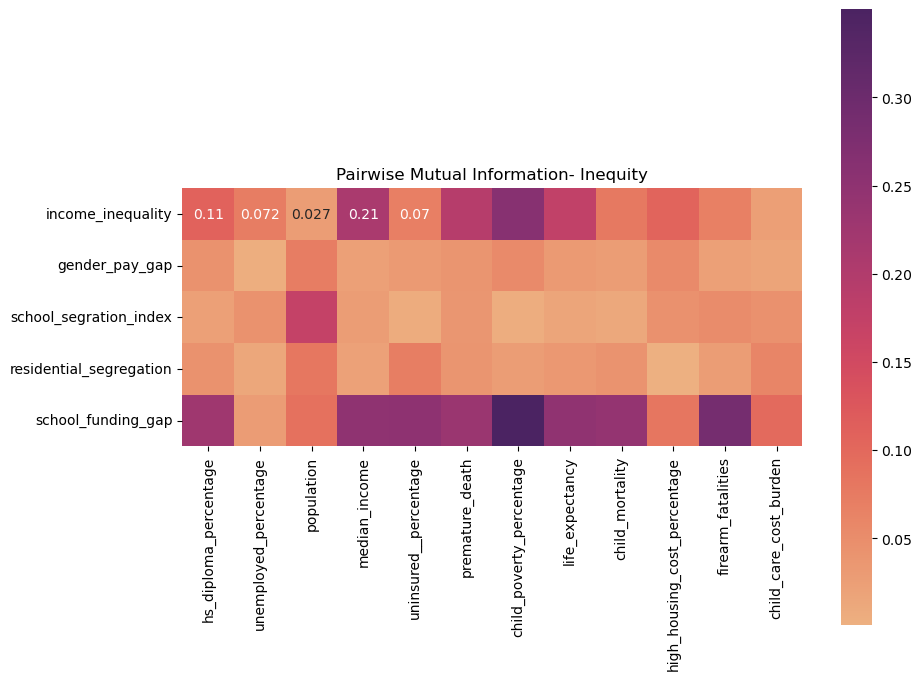

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='flare', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

## Identifying most 'informative' pairs

In [47]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap    0.349999
firearm_fatalities        school_funding_gap    0.286375
child_poverty_percentage  income_inequality     0.261776
uninsured__percentage     school_funding_gap    0.251514
median_income             school_funding_gap    0.249700
life_expectancy           school_funding_gap    0.248451
child_mortality           school_funding_gap    0.242537
premature_death           school_funding_gap    0.232733
hs_diploma_percentage     school_funding_gap    0.226240
median_income             income_inequality     0.210404
premature_death           income_inequality     0.191789
life_expectancy           income_inequality     0.175347
dtype: float64


### Selecting most 'informative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

In [48]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_party[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality'],
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

# Descriptive Statistics for Selected Variables

In [60]:
agg_select_subset.describe()

,school_funding_gap,child_poverty_percentage,income_inequality,firearm_fatalities,median_income,life_expectancy,premature_death
count,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000
mean,-804.972237,0.188401,4.601347,16.766254,67337.940534,74.852579,10482.455800
std,6428.722095,0.076617,0.712400,7.598026,16490.494964,3.224961,3315.197567
min,-46776.990000,0.031000,2.882000,1.859000,34176.000000,63.845000,3990.294000
25%,-3452.357750,0.131000,4.100000,11.692500,55568.000000,72.604750,8089.242750
50%,-309.820000,0.181500,4.489000,15.872000,64090.500000,74.880000,10155.796000
75%,2283.419000,0.232000,4.976500,20.471750,75447.000000,77.070750,12482.990000
max,21187.845000,0.536000,8.278000,79.459000,144807.000000,89.667000,27851.414000


## Variance 

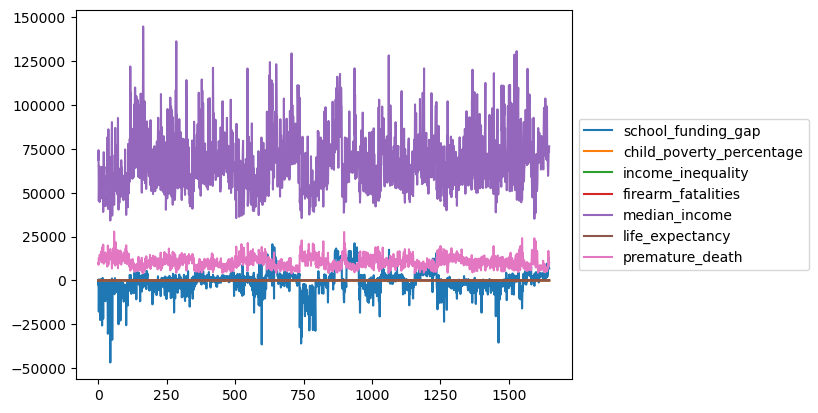

In [61]:
# Profile plot showing variance across variables
ax = agg_select_subset.plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [81]:
agg_select_subset.var(numeric_only=True)

school_funding_gap          4.132847e+07
child_poverty_percentage    5.870140e-03
income_inequality           5.075141e-01
firearm_fatalities          5.772999e+01
median_income               2.719364e+08
life_expectancy             1.040037e+01
premature_death             1.099053e+07
dtype: float64

## Correlation 

<Axes: >

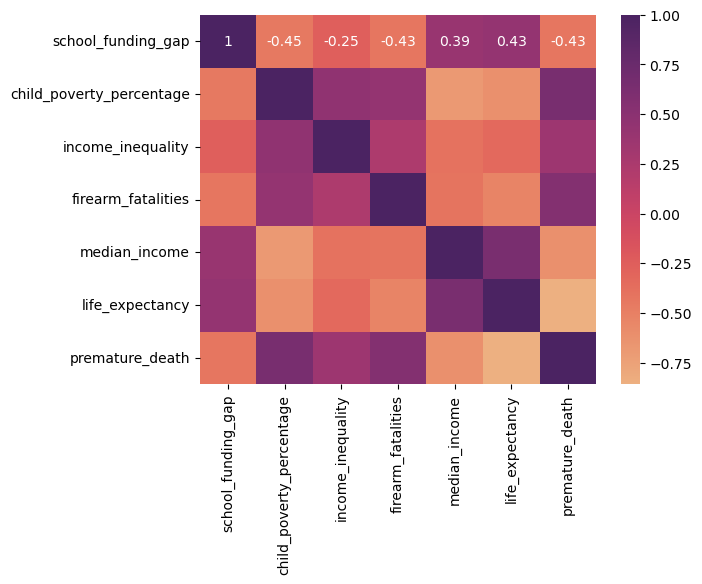

In [62]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='flare')

### Correlation Pairs

In [54]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

child_poverty_percentage   -0.637112
firearm_fatalities         -0.604100
median_income               0.496392
life_expectancy             0.564720
premature_death            -0.579993
dtype: float64


In [55]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

child_poverty_percentage    0.622599
firearm_fatalities          0.366110
median_income              -0.503023
life_expectancy            -0.458570
premature_death             0.512731
dtype: float64


### Pair Plots

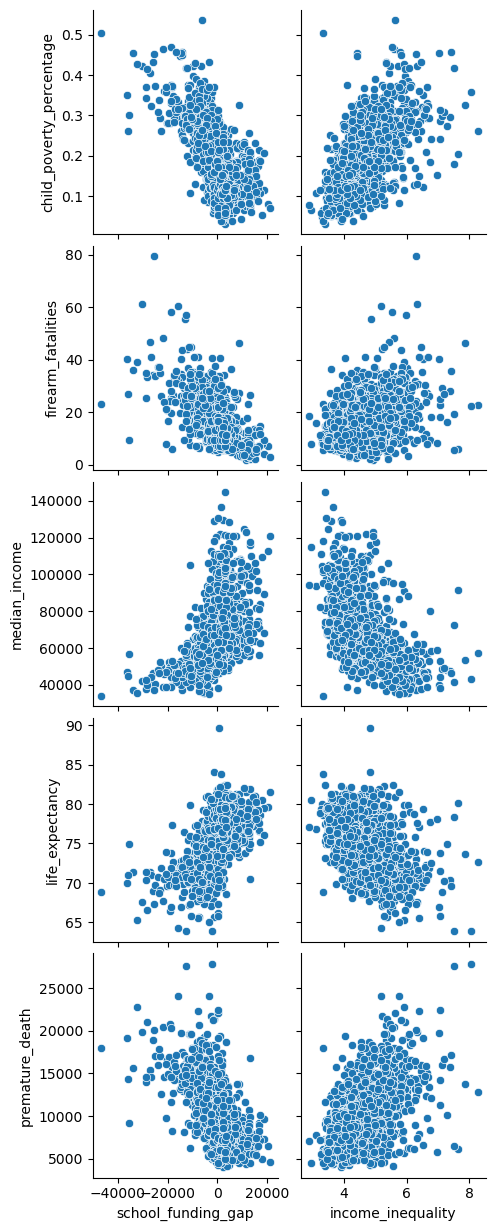

In [56]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    )     

# Regression: Selecting Best Model 

### Multivariate

### Polynomial

# Group Observations

## Defining Groups

In [ ]:
grouped_df = agg_select_subset.copy()
# adding column with inequality quantile 
grouped_df['quartile_income_inequality'] = pd.qcut(grouped_df['income_inequality'], q=4, labels=False)
# adding column defining whether county meets federal school funding requirements
grouped_df['meeting_school_funding_requirement'] = np.where(grouped_df['school_funding_gap']>=0, 'yes', 'no')

### Descriptive Stats Accross Groups

#### Mean and Median 

In [74]:
grouped_df.groupby('meeting_school_funding_requirement')['child_poverty_percentage'].mean()

meeting_school_funding_requirement
no     0.225733
yes    0.146144
Name: child_poverty_percentage, dtype: float64

In [78]:
grouped_df.groupby('meeting_school_funding_requirement')['child_poverty_percentage'].median()

meeting_school_funding_requirement
no     0.220
yes    0.142
Name: child_poverty_percentage, dtype: float64

In [75]:
grouped_df.groupby('quartile_income_inequality')['child_poverty_percentage'].mean()

quartile_income_inequality
0    0.128706
1    0.171966
2    0.197720
3    0.255590
Name: child_poverty_percentage, dtype: float64

In [77]:
grouped_df.groupby('quartile_income_inequality')['child_poverty_percentage'].median()

quartile_income_inequality
0    0.121
1    0.171
2    0.195
3    0.250
Name: child_poverty_percentage, dtype: float64

In [76]:
grouped_df.groupby('quartile_income_inequality')['child_poverty_percentage'].median()

quartile_income_inequality
0    0.121
1    0.171
2    0.195
3    0.250
Name: child_poverty_percentage, dtype: float64

In [86]:
grouped_df.columns

Index(['state_abbr', 'county', 'fips', 'school_funding_gap',
       'child_poverty_percentage', 'income_inequality', 'firearm_fatalities',
       'median_income', 'life_expectancy', 'premature_death',
       'political_party', 'quartile_income_inequality',
       'meeting_school_funding_requirement'],
      dtype='object')

## Overview

### Facet Grids

### Scatter Plots- overlayed groups 

<Axes: xlabel='school_funding_gap', ylabel='premature_death'>

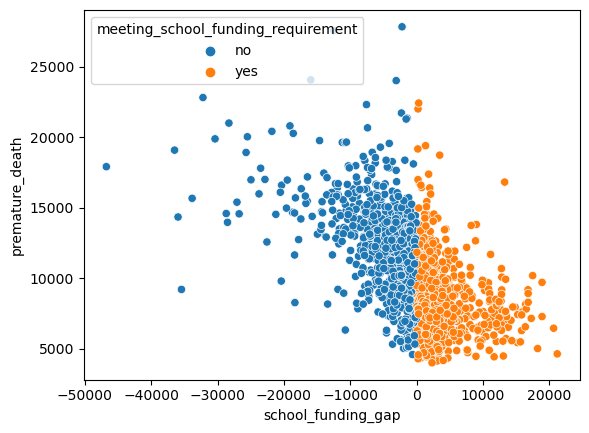

In [91]:
sns.scatterplot(data=grouped_df, x='school_funding_gap', y='premature_death', hue='meeting_school_funding_requirement')

# Chi-Squared Testing

### School Funding

### Income  Inequality

### Political Party

# Conclusion